# 9章

以下のサイトを参考にコードを記述。

https://mori-memo.hateblo.jp/archive/category/%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86100%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2024-01-11 02:45:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [      <=>           ]  27.87M  26.4MB/s    in 1.1s    

2024-01-11 02:45:27 (26.4 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
text = train.iloc[1, train.columns.get_loc('TITLE')]
text

'Amazon Plans to Fight FTC Over Mobile-App Purchases'

In [5]:
train['TITLE'].iloc[1]

'Amazon Plans to Fight FTC Over Mobile-App Purchases'

In [6]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int) #辞書初期化
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('頻度上位20語')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 9405

頻度上位20語
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


In [7]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [8]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


In [9]:
import torch
import torch.nn as nn

vocab_size = 4
emb_dim = 5
embeddings = nn.Embedding(vocab_size, emb_dim)
# 0番目の単語なので，[0]をTensorに変換
word = torch.tensor([0,1,2,3])
embed_word = embeddings(word)
print(embed_word)
print(word.shape, '->', embed_word.shape)

tensor([[ 0.2203, -0.0847,  0.8159, -0.1132, -0.1061],
        [ 0.6224,  0.4766, -0.8896, -0.5568,  0.4382],
        [ 0.1936,  0.1893,  0.7165, -0.7888,  0.8976],
        [-1.4606,  1.5033,  0.3868, -0.5230,  0.6949]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4]) -> torch.Size([4, 5])


In [10]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
    return hidden

In [11]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X.iloc[index]
    inputs = self.tokenizer(text)

    return ({'inputs': torch.tensor(inputs, dtype=torch.int64),'labels': torch.tensor(self.y[index], dtype=torch.int64)})

In [12]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


In [13]:
import torch
x = torch.zeros(2, 3, 4, 5, 6)
print(x.size())
print(x.unsqueeze(1).size())
print(x.size())
print(x.size()[0:2])

torch.Size([2, 3, 4, 5, 6])
torch.Size([2, 1, 3, 4, 5, 6])
torch.Size([2, 3, 4, 5, 6])
torch.Size([2, 3])


In [14]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(input)
print("\n")
print(output)

tensor([[-0.5940,  0.1671, -0.9382],
        [-1.4475,  2.6432,  0.4868]])


tensor([[0.2598, 0.5561, 0.1841],
        [0.0148, 0.8830, 0.1022]])


In [15]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs'] #titleのID表記したtensor
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeでバッチの大きさ1を追加

tensor([[0.1781, 0.2239, 0.4536, 0.1444]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1621, 0.1394, 0.2722, 0.4263]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2005, 0.5417, 0.1196, 0.1382]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4099, 0.0675, 0.2891, 0.2335]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1430, 0.3820, 0.2189, 0.2562]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2172, 0.2733, 0.2689, 0.2406]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4636, 0.1626, 0.1617, 0.2121]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2928, 0.2669, 0.2446, 0.1958]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3026, 0.3618, 0.1288, 0.2068]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4603, 0.2050, 0.1373, 0.1975]], grad_fn=<SoftmaxBackward0>)


In [16]:
a = torch.randn(4, 4)
print(a)
print("\n")
print(torch.argmax(a))

tensor([[ 0.0950, -1.0679, -1.8670, -1.6790],
        [-0.4643, -0.7640, -1.2374,  1.2164],
        [-0.5528,  0.3566, -0.6921, -0.9167],
        [-0.2029, -0.8906, -0.9525,  1.6788]])


tensor(15)


In [17]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader: #バッチごとに取り出して処理
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [18]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [19]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1175, accuracy_train: 0.5154, loss_valid: 1.1536, accuracy_valid: 0.4865, 59.4355sec
epoch: 2, loss_train: 1.0428, accuracy_train: 0.5731, loss_valid: 1.1052, accuracy_valid: 0.5367, 54.1616sec
epoch: 3, loss_train: 0.9149, accuracy_train: 0.6568, loss_valid: 1.0183, accuracy_valid: 0.6093, 51.6337sec
epoch: 4, loss_train: 0.7648, accuracy_train: 0.7298, loss_valid: 0.8788, accuracy_valid: 0.6834, 52.3125sec
epoch: 5, loss_train: 0.6707, accuracy_train: 0.7626, loss_valid: 0.8075, accuracy_valid: 0.7201, 50.9043sec
epoch: 6, loss_train: 0.6105, accuracy_train: 0.7850, loss_valid: 0.7699, accuracy_valid: 0.7298, 51.1060sec
epoch: 7, loss_train: 0.5522, accuracy_train: 0.8016, loss_valid: 0.7324, accuracy_valid: 0.7410, 51.4018sec
epoch: 8, loss_train: 0.5125, accuracy_train: 0.8111, loss_valid: 0.6949, accuracy_valid: 0.7560, 51.4550sec
epoch: 9, loss_train: 0.4965, accuracy_train: 0.8161, loss_valid: 0.6902, accuracy_valid: 0.7575, 50.4972sec
epoch: 10, loss_tra

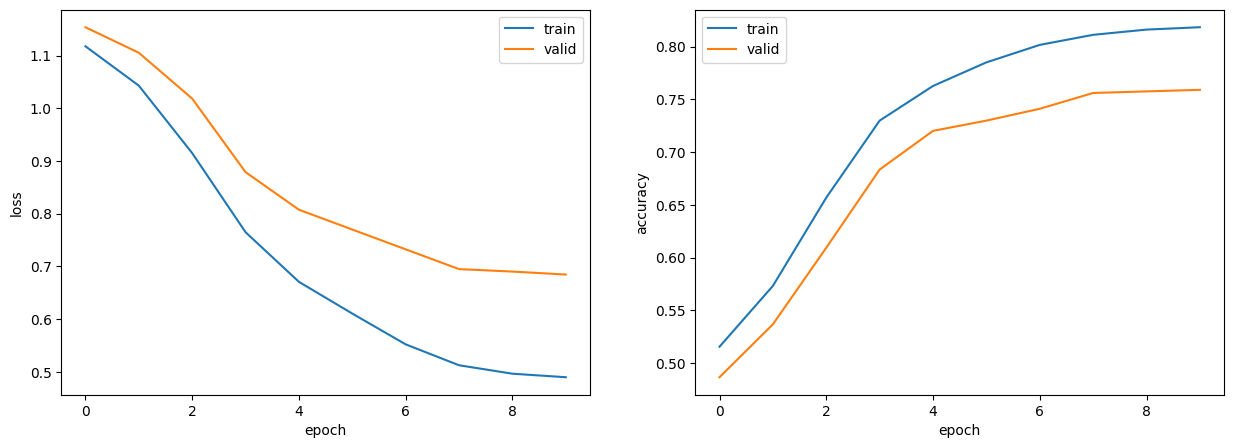

正解率（学習データ）：0.818
正解率（評価データ）：0.772


In [20]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [21]:
import numpy as np
a = np.array([1,2,3,4,5])
print(a.shape[0])

5


In [22]:
a = torch.LongTensor([[2,1], [2, 3]])
print(a)
print(a.dtype)

tensor([[2, 1],
        [2, 3]])
torch.int64


In [23]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx) #最大系列長でpadding
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [24]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2372, accuracy_train: 0.4247, loss_valid: 1.2481, accuracy_valid: 0.4169, 10.7480sec
epoch: 2, loss_train: 1.2339, accuracy_train: 0.4461, loss_valid: 1.2630, accuracy_valid: 0.4424, 9.9164sec
epoch: 3, loss_train: 1.1362, accuracy_train: 0.5230, loss_valid: 1.1531, accuracy_valid: 0.5030, 9.7951sec
epoch: 4, loss_train: 1.1055, accuracy_train: 0.5611, loss_valid: 1.1413, accuracy_valid: 0.5329, 9.3545sec
epoch: 5, loss_train: 1.1005, accuracy_train: 0.5808, loss_valid: 1.1691, accuracy_valid: 0.5299, 9.7710sec
epoch: 6, loss_train: 1.1609, accuracy_train: 0.5312, loss_valid: 1.2220, accuracy_valid: 0.4903, 9.8467sec
epoch: 7, loss_train: 1.1372, accuracy_train: 0.5334, loss_valid: 1.1931, accuracy_valid: 0.4910, 10.8753sec
epoch: 8, loss_train: 1.0948, accuracy_train: 0.5737, loss_valid: 1.1652, accuracy_valid: 0.5277, 9.4822sec
epoch: 9, loss_train: 1.0768, accuracy_train: 0.5818, loss_valid: 1.1473, accuracy_valid: 0.5292, 9.8635sec
epoch: 10, loss_train: 1.0

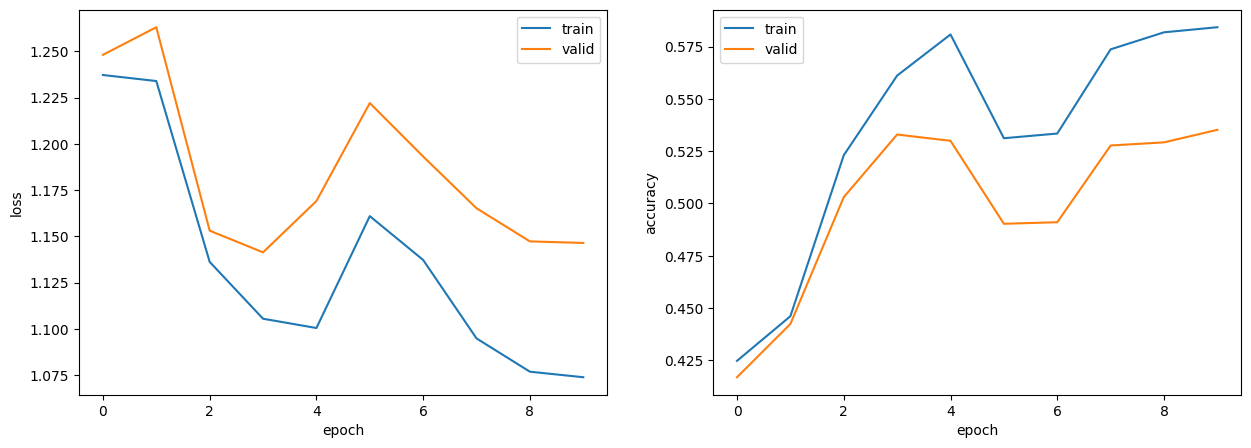

正解率（学習データ）：0.584
正解率（評価データ）：0.548


In [25]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [29]:
from google.colab import drive
drive.mount('/content/drive')
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('drive/MyDrive/100knock/GoogleNews-vectors-negative300.bin.gz', binary=True)

Mounted at /content/drive


In [30]:
# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9174 / 9406
torch.Size([9406, 300])


In [31]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2 bool型 False == 0 True == 1
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

In [32]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1758, accuracy_train: 0.4226, loss_valid: 1.1867, accuracy_valid: 0.4079, 10.6816sec
epoch: 2, loss_train: 1.1527, accuracy_train: 0.4666, loss_valid: 1.1770, accuracy_valid: 0.4409, 10.1314sec
epoch: 3, loss_train: 1.0802, accuracy_train: 0.5958, loss_valid: 1.0985, accuracy_valid: 0.5749, 10.8616sec
epoch: 4, loss_train: 0.9959, accuracy_train: 0.6435, loss_valid: 1.0103, accuracy_valid: 0.6355, 10.0519sec
epoch: 5, loss_train: 0.9551, accuracy_train: 0.6582, loss_valid: 0.9729, accuracy_valid: 0.6430, 9.0629sec
epoch: 6, loss_train: 1.0656, accuracy_train: 0.6054, loss_valid: 1.0984, accuracy_valid: 0.5763, 10.0389sec
epoch: 7, loss_train: 1.0151, accuracy_train: 0.6210, loss_valid: 1.0436, accuracy_valid: 0.5988, 10.1653sec
epoch: 8, loss_train: 1.0030, accuracy_train: 0.6320, loss_valid: 1.0327, accuracy_valid: 0.6130, 9.4916sec
epoch: 9, loss_train: 0.9314, accuracy_train: 0.6643, loss_valid: 0.9612, accuracy_valid: 0.6460, 9.9512sec
epoch: 10, loss_train:

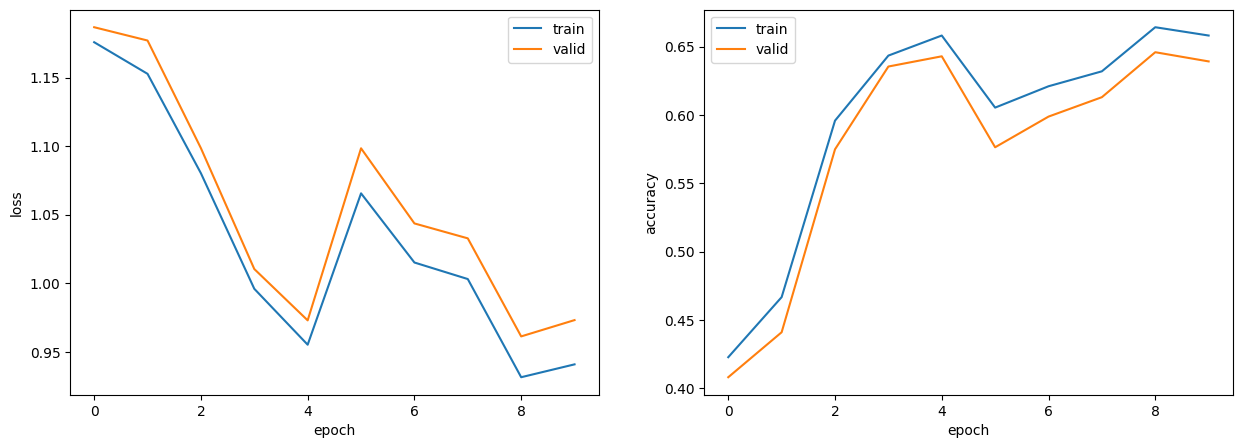

正解率（学習データ）：0.658
正解率（評価データ）：0.654


In [33]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [34]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True) #双方向

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1775, accuracy_train: 0.4101, loss_valid: 1.1925, accuracy_valid: 0.4019, 10.9344sec
epoch: 2, loss_train: 1.2137, accuracy_train: 0.4228, loss_valid: 1.2555, accuracy_valid: 0.4132, 11.8027sec
epoch: 3, loss_train: 1.0691, accuracy_train: 0.5857, loss_valid: 1.0963, accuracy_valid: 0.5696, 11.1548sec
epoch: 4, loss_train: 1.0911, accuracy_train: 0.5901, loss_valid: 1.1393, accuracy_valid: 0.5696, 10.7497sec
epoch: 5, loss_train: 1.1835, accuracy_train: 0.5344, loss_valid: 1.2202, accuracy_valid: 0.5142, 10.8917sec
epoch: 6, loss_train: 1.0305, accuracy_train: 0.6092, loss_valid: 1.0896, accuracy_valid: 0.5846, 11.1751sec
epoch: 7, loss_train: 0.9341, accuracy_train: 0.6536, loss_valid: 0.9782, accuracy_valid: 0.6362, 12.3215sec
epoch: 8, loss_train: 1.0069, accuracy_train: 0.6191, loss_valid: 1.0741, accuracy_valid: 0.5958, 11.0701sec
epoch: 9, loss_train: 0.9412, accuracy_train: 0.6416, loss_valid: 1.0024, accuracy_valid: 0.6220, 10.3263sec
epoch: 10, loss_tra

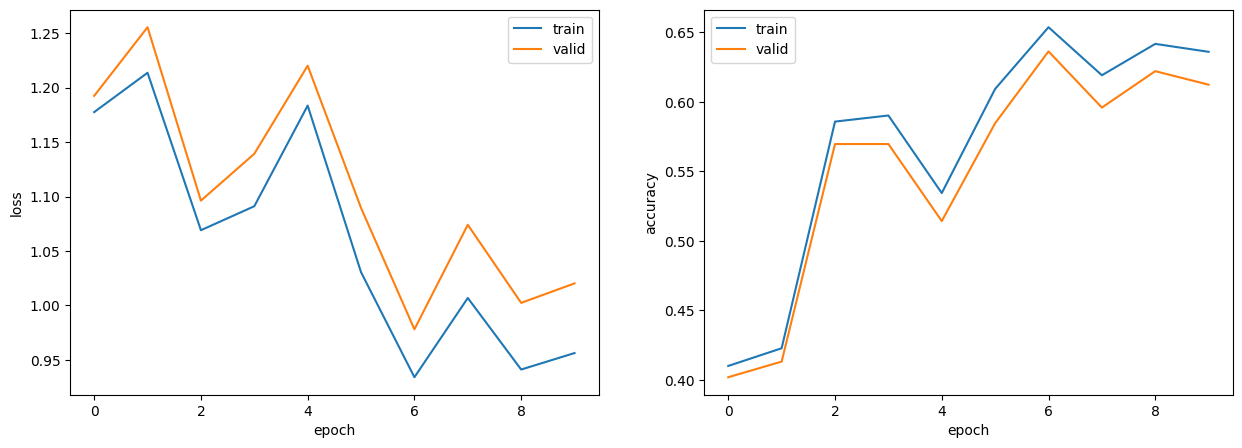

正解率（学習データ）：0.636
正解率（評価データ）：0.620


In [35]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [36]:
m = nn.Dropout(0.3)
input = torch.randn(2, 10)
output = m(input)

print(output)

tensor([[-0.4648,  1.4919,  3.1671,  1.0255,  1.5141,  0.8341,  0.2833, -0.1145,
         -0.4184, -0.0000],
        [-1.0747,  1.6890, -2.8355, -0.0000, -0.9811,  0.2562,  2.2510,  0.2020,
          0.1517,  0.0000]])


In [37]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [38]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeでbatch_sizeを1として追加

tensor([[0.1962, 0.3084, 0.2469, 0.2484]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2585, 0.2624, 0.2375, 0.2415]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2038, 0.3446, 0.2146, 0.2370]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2475, 0.2705, 0.2231, 0.2589]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2355, 0.3204, 0.2163, 0.2278]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2244, 0.3180, 0.2521, 0.2055]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2838, 0.2762, 0.2110, 0.2290]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2161, 0.3015, 0.2534, 0.2290]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2410, 0.2752, 0.2430, 0.2408]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2235, 0.2917, 0.2663, 0.2185]], grad_fn=<SoftmaxBackward0>)


In [39]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0664, accuracy_train: 0.5492, loss_valid: 1.0812, accuracy_valid: 0.5531, 10.2936sec
epoch: 2, loss_train: 0.9849, accuracy_train: 0.6273, loss_valid: 1.0155, accuracy_valid: 0.6265, 9.8139sec
epoch: 3, loss_train: 0.9112, accuracy_train: 0.6765, loss_valid: 0.9509, accuracy_valid: 0.6729, 9.3895sec
epoch: 4, loss_train: 0.8476, accuracy_train: 0.7134, loss_valid: 0.9033, accuracy_valid: 0.6939, 8.3514sec
epoch: 5, loss_train: 0.8063, accuracy_train: 0.7241, loss_valid: 0.8696, accuracy_valid: 0.6991, 9.3213sec
epoch: 6, loss_train: 0.7736, accuracy_train: 0.7346, loss_valid: 0.8471, accuracy_valid: 0.7141, 9.2856sec
epoch: 7, loss_train: 0.7530, accuracy_train: 0.7435, loss_valid: 0.8336, accuracy_valid: 0.7223, 8.3571sec
epoch: 8, loss_train: 0.7409, accuracy_train: 0.7463, loss_valid: 0.8243, accuracy_valid: 0.7238, 9.1674sec
epoch: 9, loss_train: 0.7352, accuracy_train: 0.7484, loss_valid: 0.8207, accuracy_valid: 0.7253, 8.9877sec
epoch: 10, loss_train: 0.73

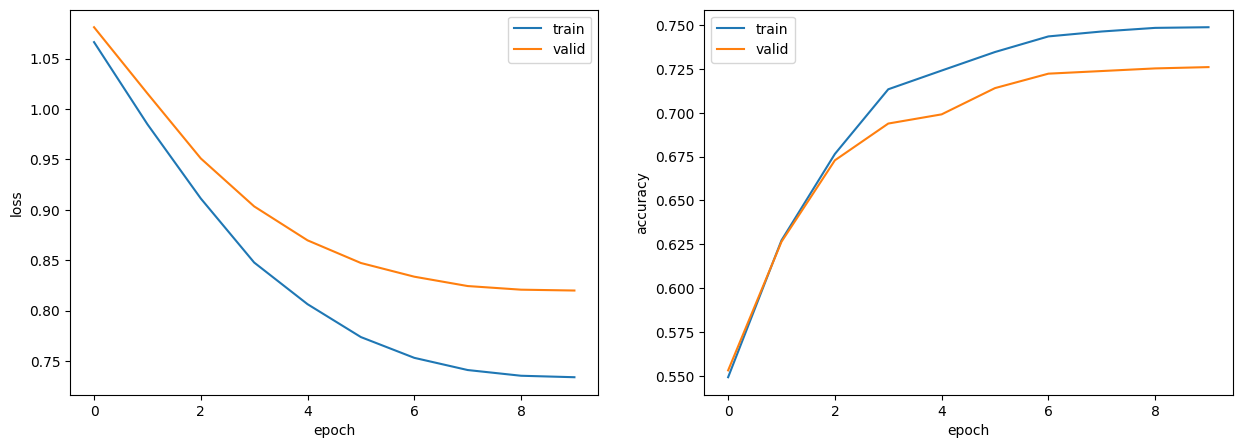

正解率（学習データ）：0.749
正解率（評価データ）：0.716


In [40]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [41]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb).squeeze(3)) for conv in (self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size()[2]) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [42]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [43]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.cuda.set_device(0)

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)

  return loss_valid

In [47]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=120)

[I 2024-01-11 03:15:29,303] A new study created in memory with name: no-name-8a4ee90f-fc18-4338-ba6b-74629cc39280
<ipython-input-43-462da3657e08>:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
<ipython-input-43-462da3657e08>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-43-462da3657e08>:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...)

epoch: 1, loss_train: 1.1163, accuracy_train: 0.5422, loss_valid: 1.1222, accuracy_valid: 0.5314, 33.1796sec
epoch: 2, loss_train: 1.0726, accuracy_train: 0.5632, loss_valid: 1.0893, accuracy_valid: 0.5449, 28.7931sec
epoch: 3, loss_train: 1.0350, accuracy_train: 0.5962, loss_valid: 1.0580, accuracy_valid: 0.5883, 28.9840sec
epoch: 4, loss_train: 0.9999, accuracy_train: 0.6106, loss_valid: 1.0263, accuracy_valid: 0.6100, 28.7351sec
epoch: 5, loss_train: 0.9628, accuracy_train: 0.6585, loss_valid: 1.0020, accuracy_valid: 0.6475, 31.2407sec
epoch: 6, loss_train: 0.9257, accuracy_train: 0.6853, loss_valid: 0.9700, accuracy_valid: 0.6647, 35.5266sec
epoch: 7, loss_train: 0.8904, accuracy_train: 0.6983, loss_valid: 0.9398, accuracy_valid: 0.6834, 29.0228sec
epoch: 8, loss_train: 0.8582, accuracy_train: 0.7091, loss_valid: 0.9149, accuracy_valid: 0.6909, 28.9717sec
epoch: 9, loss_train: 0.8287, accuracy_train: 0.7215, loss_valid: 0.8934, accuracy_valid: 0.7028, 28.9057sec
epoch: 10, loss_tra

[I 2024-01-11 03:30:19,753] Trial 0 finished with value: 0.7647335587887087 and parameters: {'emb_size': 300.0, 'out_channels': 150.0, 'drop_rate': 0.2, 'learning_rate': 0.0020578777992292644, 'momentum': 0.6, 'batch_size': 16.0}. Best is trial 0 with value: 0.7647335587887087.


In [48]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.765
  Params: 
    emb_size: 300.0
    out_channels: 150.0
    drop_rate: 0.2
    learning_rate: 0.0020578777992292644
    momentum: 0.6
    batch_size: 16.0


In [51]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
#EMB_SIZE = int(trial.params['emb_size'])
EMB_SIZE = 300;
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
#OUT_CHANNELS = int(trial.params['out_channels'])
OUT_CHANNELS = 100
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
#DROP_RATE = trial.params['drop_rate']
DROP_RATE = 0.4
#LEARNING_RATE = trial.params['learning_rate']
LEARNING_RATE = 0.013345934577557608
#BATCH_SIZE = int(trial.params['batch_size'])
BATCH_SIZE = 32
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.cuda.set_device(0)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

textCNN(
  (emb): Embedding(9406, 300, padding_idx=9405)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)
epoch: 1, loss_train: 0.8254, accuracy_train: 0.6936, loss_valid: 0.9147, accuracy_valid: 0.6430, 26.1778sec
epoch: 2, loss_train: 0.5787, accuracy_train: 0.7887, loss_valid: 0.7324, accuracy_valid: 0.7343, 24.8508sec
epoch: 3, loss_train: 0.4007, accuracy_train: 0.8677, loss_valid: 0.6234, accuracy_valid: 0.7769, 25.0414sec
epoch: 4, loss_train: 0.2759, accuracy_train: 0.9306, loss_valid: 0.5681, accuracy_valid: 0.7979, 23.0706sec
epoch: 5, loss_train: 0.1920, accuracy_train: 0.9487, loss_valid: 0.5230, accuracy_valid: 0.8121, 24.8470sec
epoch: 6, loss_train: 0.1320, accuracy_train: 0.9809, l

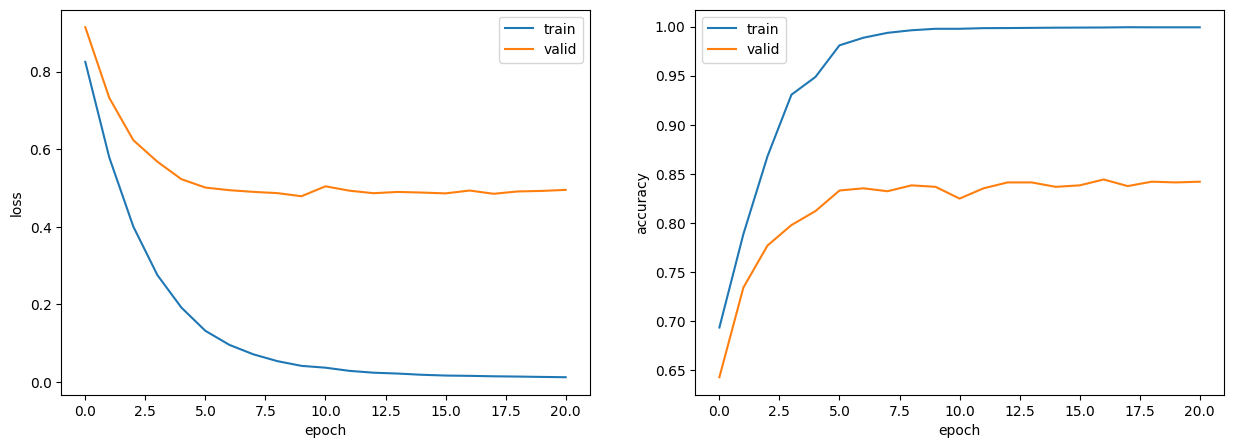

正解率（学習データ）：0.999
正解率（評価データ）：0.859


In [52]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [53]:
!pip install transformers

In [54]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [55]:
# Datasetの定義
class NewsDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X.iloc[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [56]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
         2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [57]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

In [58]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [59]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

epoch: 1, loss_train: 0.0814, accuracy_train: 0.9548, loss_valid: 0.1089, accuracy_valid: 0.9266, 74.1524sec
epoch: 2, loss_train: 0.0512, accuracy_train: 0.9695, loss_valid: 0.1116, accuracy_valid: 0.9334, 76.0123sec
epoch: 3, loss_train: 0.0279, accuracy_train: 0.9868, loss_valid: 0.1088, accuracy_valid: 0.9274, 65.7198sec
epoch: 4, loss_train: 0.0194, accuracy_train: 0.9903, loss_valid: 0.1177, accuracy_valid: 0.9244, 70.1852sec


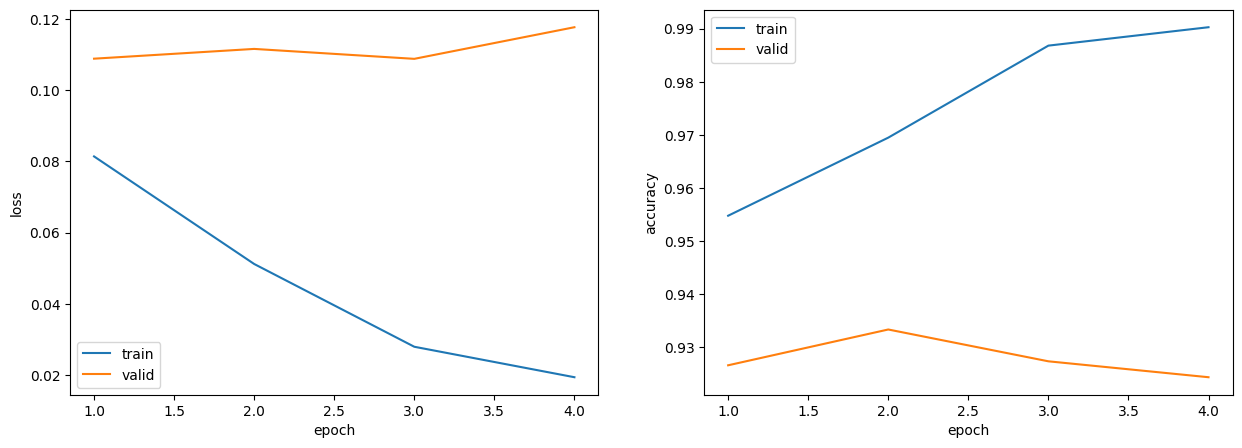

In [60]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [61]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

正解率（学習データ）：0.990
正解率（検証データ）：0.924
正解率（評価データ）：0.943
